In [1]:
import os
import math
import pandas as pd
import sidetable
import numpy as np
import openpyxl
import dataframe_image as dfi
from pathlib import Path
import matplotlib.pyplot as plt
import textwrap, csv, sys, getopt
import time, datetime, random, calendar
from datetime import timedelta, date
from calendar import monthrange
from matplotlib import rcParams, font_manager
from matplotlib.dates import DateFormatter
from dateutil.rrule import rrule, MONTHLY
import warnings
import bisect
import drawsvg as draw

warnings.filterwarnings('ignore')

In [2]:
####
## Defining visual elements like current year, username, font styles, colors, and labels
####

## Set current year
currentyear = "2023"

## Set name for slides
username = "HandmadePhD"

## Set the font family to "Patrick Hand"
rcParams["font.family"] = "Patrick Hand"

## Update the default font size for plots to 18
rcParams.update({"font.size": 24})

## List of 12 colors for each month in hex format
clrs = ["#155DCF", #tang-blue
        "#0C3576", #yale-blue
        "#FF5501", #orange-pantone
        "#B43B00", #rust
        "#FFABCF", #lavender-pink
        "#FF5FA3", #cyclamen-pink
        "#FFC601", #mikado-yellow
        "#B48B00", #dark-goldenrod
        "#2BD8A3", #emerald
        "#1C9A74", #jungle-green
        "#C9B5FF", #mauve
        "#9169FF"] #medium-slate-blue

## List of months
month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

## Label for figures
month_label = currentyear + " Recap"

In [3]:
####
## Functions and Dictonaries
####

## Dictonary mapping colors to text colors (black or white)
clrs_txt = {
    # Map these colors to "black"
    **dict.fromkeys(["white", "tab:gray", "whitesmoke", "gold", "#FFABCF", "#FFC601", "#C9B5FF"], "black"),
    
    # Map these colors to "white"
    **dict.fromkeys(["tab:blue", "tab:orange",  "tab:green", "tab:brown", "tab:pink", "tab:purple", "tab:red",  "#155DCF", "#FF5501", "#2BD8A3", "#0C3576", "#B43B00", "#FF5FA3", "#B48B00", "#1C9A74", "#9169FF"], "white")
}


## Wrap text labels to a specified width
def custom_label(names):
    labels = list(names)
    global wrapped_labels
    wrapped_labels = []
    for text in labels:
        wrapped_labels.append(textwrap.fill(text, width=15, break_long_words=False))
        
    return(wrapped_labels)

## Generate a list of colors for wedges, ensuring that the color list is sufficient for the wrapped labels
def custom_wedges():
    tempList = random.sample(clrs, 12)
    global colors
    colors = []
    for i in range(len(wrapped_labels)):
        if i <= 11:
            colors.append(tempList[i])
        elif i >= 12:
            colors.append(tempList[i-11])
    
    return(colors)

## Remove recentages less than 5% from pie charts
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

## Custom pie chart for data from project sheet
def custom_project_piechart():
    pctscolors = [clrs_txt[k] for k in colors]
    fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
    wedges, texts, pcts = ax.pie(tab["percent"], colors=colors, wedgeprops={"linewidth": 4, "edgecolor": "#E2EDFF"}, autopct=custom_autopct, pctdistance=0.825, startangle=random.randint(0, 360))
    for pct, color in zip(pcts, pctscolors):
        pct.set_color(color)
        
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(wrapped_labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y), horizontalalignment=horizontalalignment, **kw)
        
    center_circle = plt.Circle((0, 0), 0.65, color="#E2EDFF")
    fig.gca().add_artist(center_circle)
    plt.text(0, 0, "{}".format(tab_total), ha="center", va="center", fontsize=100)
    fig.set_facecolor("#E2EDFF")
    plt.subplots_adjust(top=0.85)
    plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
    plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Format seconds into HH:MM
def secondsToTime(seconds):
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return "%d:%02d" % (hours, minutes)

## Generate a NumPy-style array of time intervals in seconds up to the specified maximum value
def interval(max_value, multiplier , range_limit):
    intvals = [3600 * i * multiplier for i in range(range_limit)]
    i = bisect.bisect_right(intvals, max_value)
    return intvals[:i + 1]

## Time dictonary
time_interval = 3600
time_dict = {i * time_interval: f"{i:02d}:00" for i in range(1000)}

In [52]:
####
## Title Figure
####
len_x = 1350
len_y = 1080

cx = len_x / 2
cy = len_y / 2

## Begin drawing
s0 = draw.Drawing(len_x, len_y, origin=(0, 0), displayInline=False)
s0.embed_google_font('Patrick Hand', text=set('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.@')) # Set font and characters

## Draw background
s0.append(draw.Rectangle(0, 0, len_x, len_y, fill='#E2EDFF'))

## Select random colors
fill_clrs = random.sample(clrs, 4)
font_clrs = [clrs_txt[k] for k in fill_clrs]

## Draw rounded rectangle
s0.append(draw.Rectangle(-160, 0, 1350, 270, rx='100', stroke='none', fill=fill_clrs[0]))
s0.append(draw.Rectangle(160, 270, 1350, 270, rx='100', stroke='none', fill=fill_clrs[1]))
s0.append(draw.Rectangle(-160, 540, 1350, 270, rx='100', stroke='none', fill=fill_clrs[2]))
s0.append(draw.Rectangle(160, 810, 1350, 270, rx='100', stroke='none', fill=fill_clrs[3]))

## Draw text
s0.append(draw.Text('2023', 250, 595, 135, fill=font_clrs[0], text_anchor='middle', dominant_baseline='middle', font_family='Patrick Hand'))
s0.append(draw.Text('YEARLY', 250, 755, 405, fill=font_clrs[1], text_anchor='middle', dominant_baseline='middle', font_family='Patrick Hand'))
s0.append(draw.Text('RECAP', 250, 595, 675, fill=font_clrs[2], text_anchor='middle', dominant_baseline='middle', font_family='Patrick Hand'))
s0.append(draw.Text(username, 150, 755, 945, fill=font_clrs[3], text_anchor='middle', dominant_baseline='middle', font_family='Patrick Hand'))

## Set pixel scale
s0.set_render_size(len_x, len_y)

## Save image
s0.rasterize()  # Display as PNG
s0.save_png('title.png')

In [4]:
####
## Load datasheets
####

## Load "SPENT" sheet
df_SPENT = pd.read_excel(r"../recap-datasheet-v1.xlsx", sheet_name="SPENT", parse_dates=["DATE"])

## Load "PROJECTS" sheet
df_PROJECTS = pd.read_excel(r"../recap-datasheet-v1.xlsx", sheet_name="PROJECTS")

## Replace values in the "MADE FOR" column
df_PROJECTS["MADE FOR"].replace(to_replace=["NAOMI"], value="ME", inplace=True)
df_PROJECTS["MADE FOR"].replace(to_replace=["RYAN"], value="NOT ME", inplace=True)
df_PROJECTS["MADE FOR"].replace(to_replace=["MARLYS"], value="NOT ME", inplace=True)

## Convert date columns to datetime64 data type
df_PROJECTS["ARRIVED"] = df_PROJECTS["ARRIVED"].astype("datetime64[ns]")
df_PROJECTS["STARTED"] = df_PROJECTS["STARTED"].astype("datetime64[ns]")
df_PROJECTS["PROJECT COMPLETED"] = df_PROJECTS["PROJECT COMPLETED"].astype("datetime64[ns]")

## Create a "PROJECT TYPE" dictonary
var="PROJECT TYPE"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
type_dict = dict(zip(tab["PROJECT NAME"],tab["PROJECT TYPE"]))
type_dict.update({"BED SHEETS": "BEDDING"})
type_dict.update({"PERIOD PANTY SET OF 4": "LINGERIE"})
type_dict.update({"ORANGE HASLAM HAT REDO": "ACCESSORY"})

## Load "TIME" sheet
df_TIME = pd.read_excel(r"../recap-datasheet-v1.xlsx", sheet_name="TIME", usecols="A:C,F", parse_dates=["DATE"])

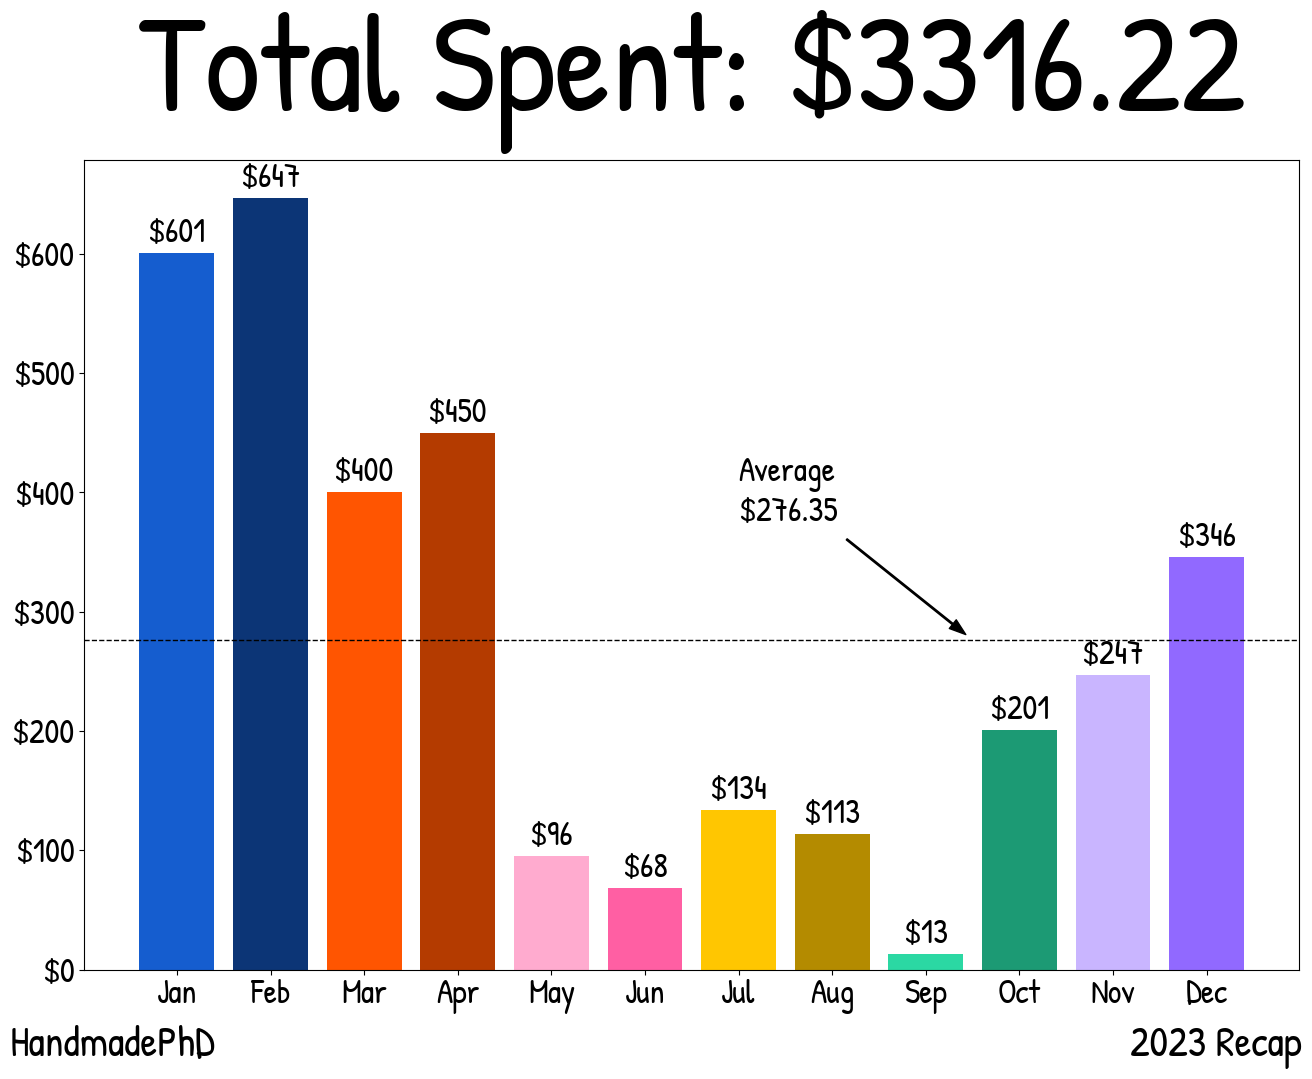

In [7]:
####
## Total spent
####

## Aggregate total "COST" per month and reset index
result = df_SPENT.groupby([df_SPENT['DATE'].dt.month]).agg({'COST':sum}).reset_index()

## Merge with a DataFrame containing month numbers (1 to 12), fill missing values with 0
result = pd.merge(result, pd.DataFrame(np.arange(1,13), columns=["DATE"]), how="right").replace(np.nan,0)

## Extract x and y values for plotting
x = result["DATE"]
y = result["COST"]

## Set labels and title for the plot
labels = month_list
title = f"Total Spent: ${'{:.2f}'.format(round(sum(y),2))}"

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
bars = ax.bar(x, y, color=clrs)

## Add labels and formatting to the bars
ax.bar_label(bars, fmt='${:,.0f}')
ax.yaxis.set_major_formatter('${x:1.0f}')

## Customize x-axis ticks and title
plt.xticks(x, labels)
plt.title(title, fontsize=100, pad=35)

## Remove y and x-axis labels
plt.ylabel("")
plt.xlabel("")

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.075, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Calculate and plot the monthly average
mn = round(np.nanmean(y),2)
plt.axhline(y=mn, color='black', linestyle='--', linewidth=1)
plt.annotate(f"Average\n${'%.2f' % mn}", xy=(9.5, mn), xytext=(7, mn+100), arrowprops=dict(width=1, headwidth=8, facecolor='black', shrink=0.05)) 

## Save the figure as an image
plt.savefig("total-spent.png", dpi=100)

## Display the plot
plt.show()

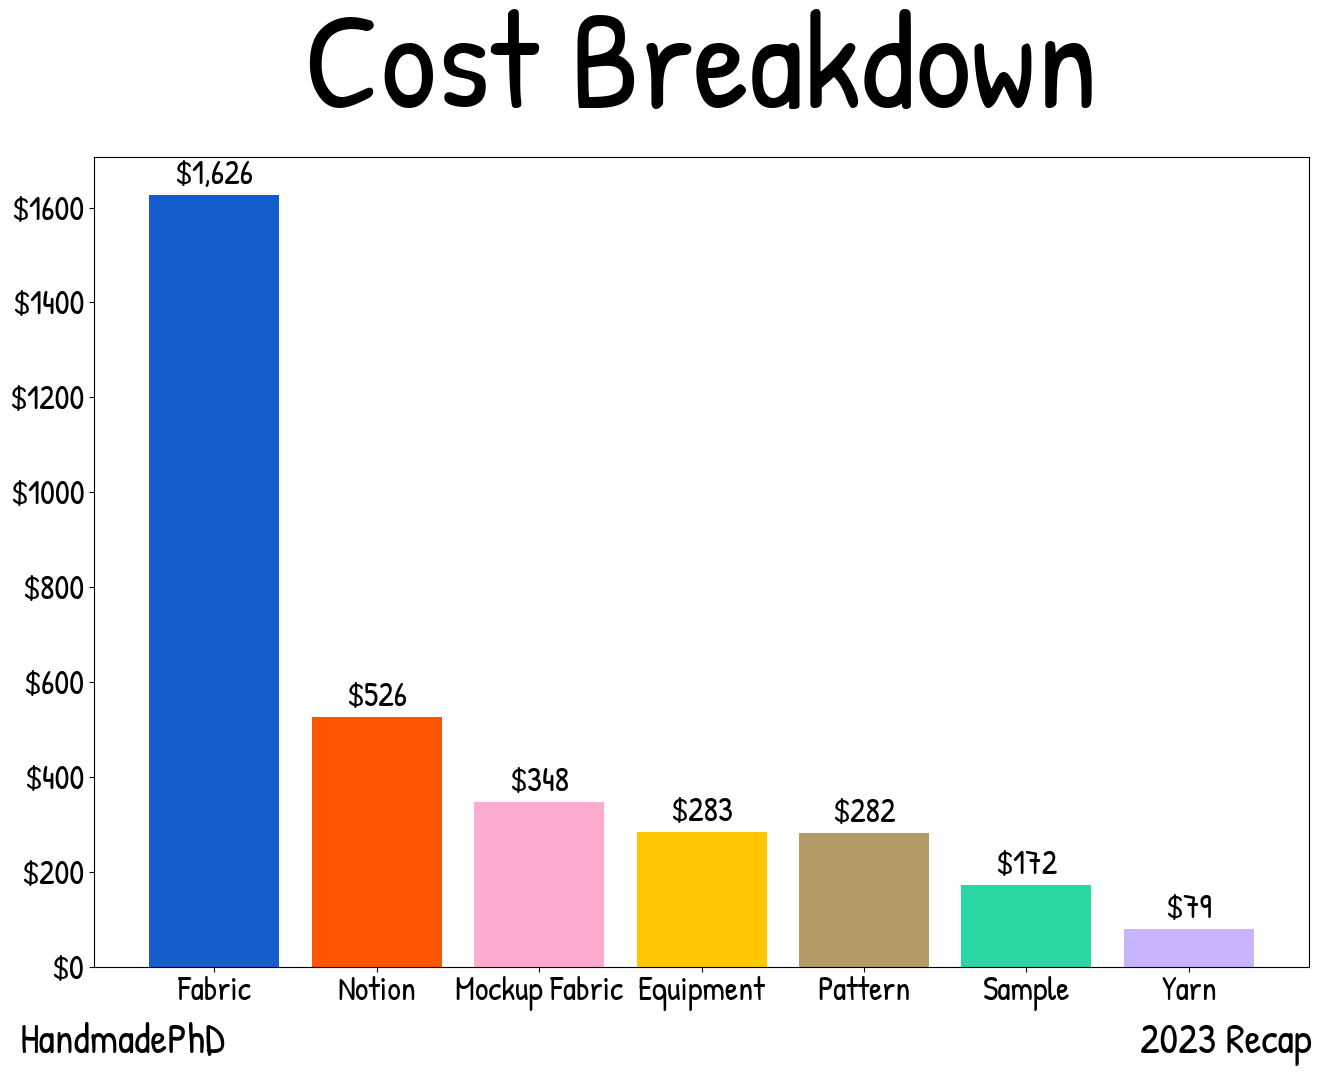

In [8]:
####
## Cost breakdown
####

## Set the variable to "CATEGORY"
var = "CATEGORY"

## Create a frequency table for the specified variable and COST, storing the result in 'tab'
tab = df_SPENT.stb.freq([var], value="COST")
tab[var] = tab[var].str.title()

## Extract x and y values for plotting
x = tab.index
y = tab["COST"]

## Wrap labels using a custom function based on the category names
labels = custom_label(tab[var])

## Set labels and title for the plot
title = "Cost Breakdown"

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
bars = ax.bar(x, y, color=["#155DCF", "#FF5501", "#FFABCF", "#FFC601", "#B49A67", "#2BD8A3", "#C9B5FF"])

## Add labels and formatting to the bars
ax.bar_label(bars, fmt='${:,.0f}')
ax.yaxis.set_major_formatter('${x:1.0f}')

## Customize x-axis ticks and title
plt.xticks(x, labels)
plt.title(title, fontsize=100, pad=35)

## Remove y and x-axis labels
plt.ylabel("")
plt.xlabel("")

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.075, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Save the figure as an image
plt.savefig("cost-breakdown.png", dpi=100)

## Display the plot
plt.show()

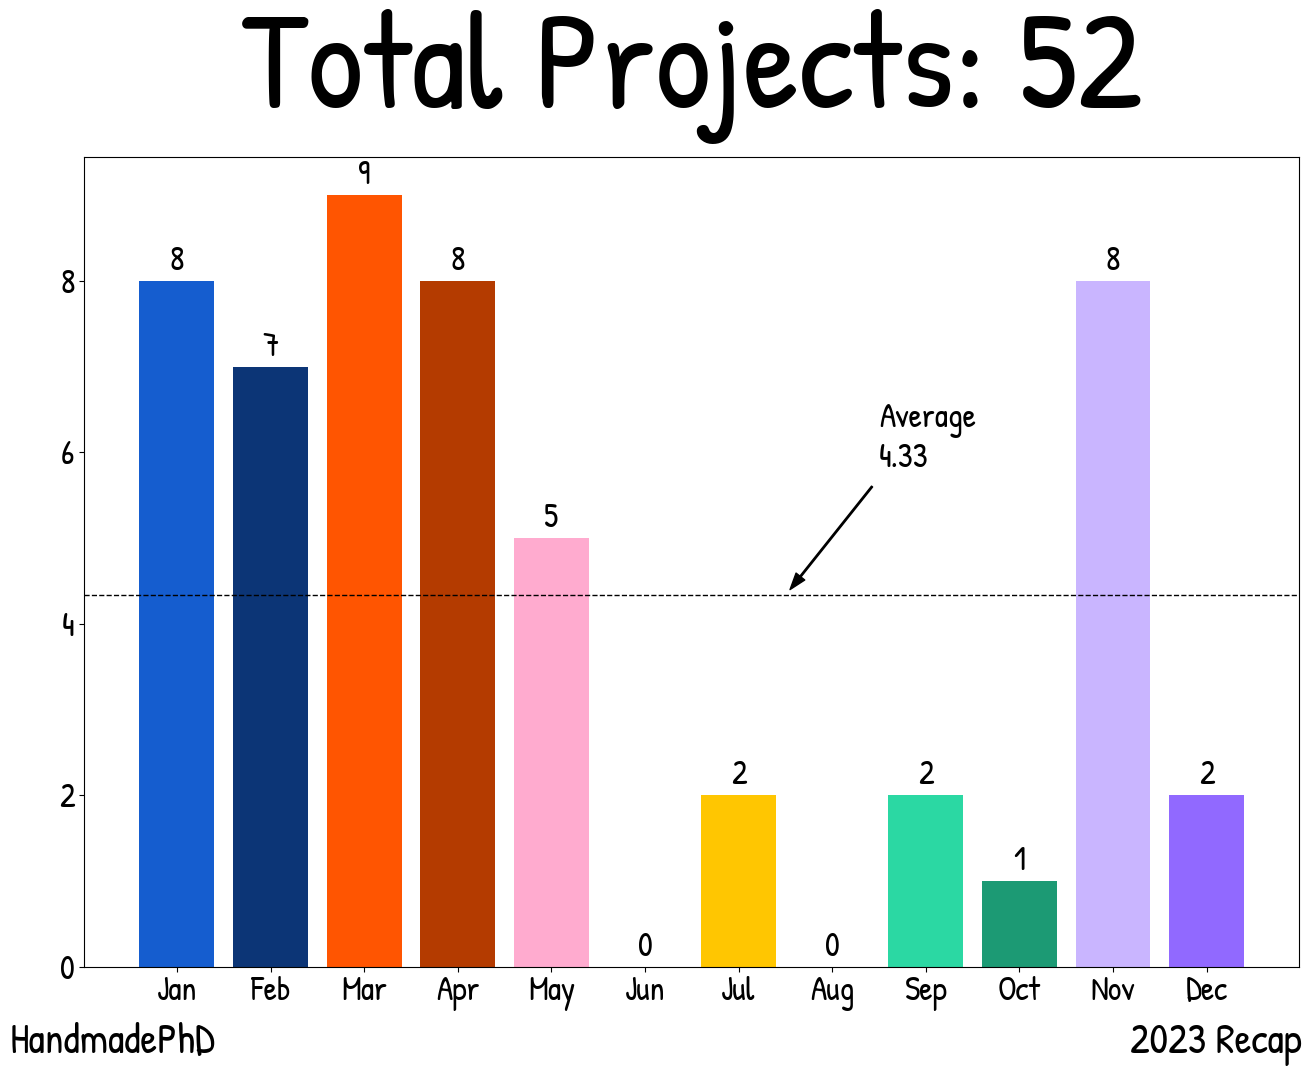

In [9]:
####
## Projects completed by month
####

## Calculate the number of unique projects completed each month
result = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month])['PROJECT NAME'].nunique().reset_index()

## Merge with a DataFrame containing month numbers (1 to 12), fill missing values with 0
result = pd.merge(result, pd.DataFrame(np.arange(1, 13), columns=["PROJECT COMPLETED"]), how="right").replace(np.nan, 0)

## Extract x and y values for plotting
x = result["PROJECT COMPLETED"]
y = result["PROJECT NAME"]

## Set labels and title for the plot
labels = month_list
title = f"Total Projects: {int(sum(y))}"

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
bars = ax.bar(x, y, color=clrs)

## Add labels and formatting to the bars
ax.bar_label(bars, fmt='{:,.0f}')

## Customize x-axis ticks and title
plt.xticks(x, labels)
plt.title(title, fontsize=100, pad=35)

## Remove y and x-axis labels
plt.ylabel("")
plt.xlabel("")

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.075, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Calculate and plot the monthly average
mn = round(np.nanmean(y), 2)
plt.axhline(y=mn, color='black', linestyle='--', linewidth=1, label='Avg')
plt.annotate(f"Average\n{mn}", xy=(7.5, mn), xytext=(8.5, mn + 1.5), arrowprops=dict(width=1, headwidth=8, facecolor='black', shrink=0.05))

## Save the figure as an image
plt.savefig("total-projects.png", dpi=100)

## Display the plot
plt.show()

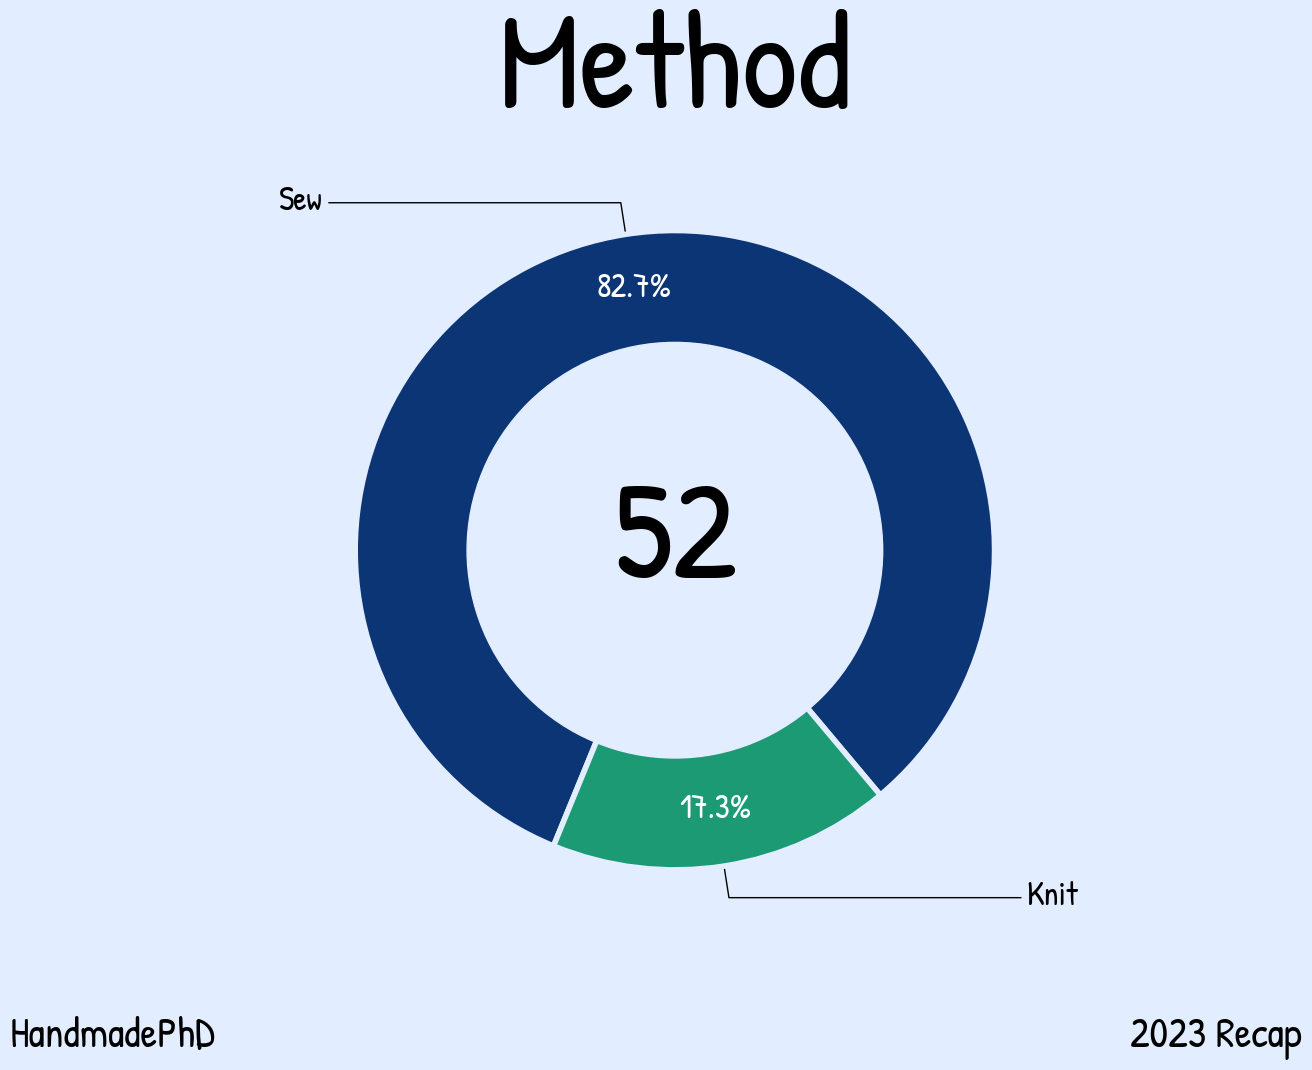

In [10]:
####
## METHOD
####
var="METHOD"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Method", fontsize=100, loc="center")
plt.savefig("method.png", dpi=100)

## Display the plot
plt.show()

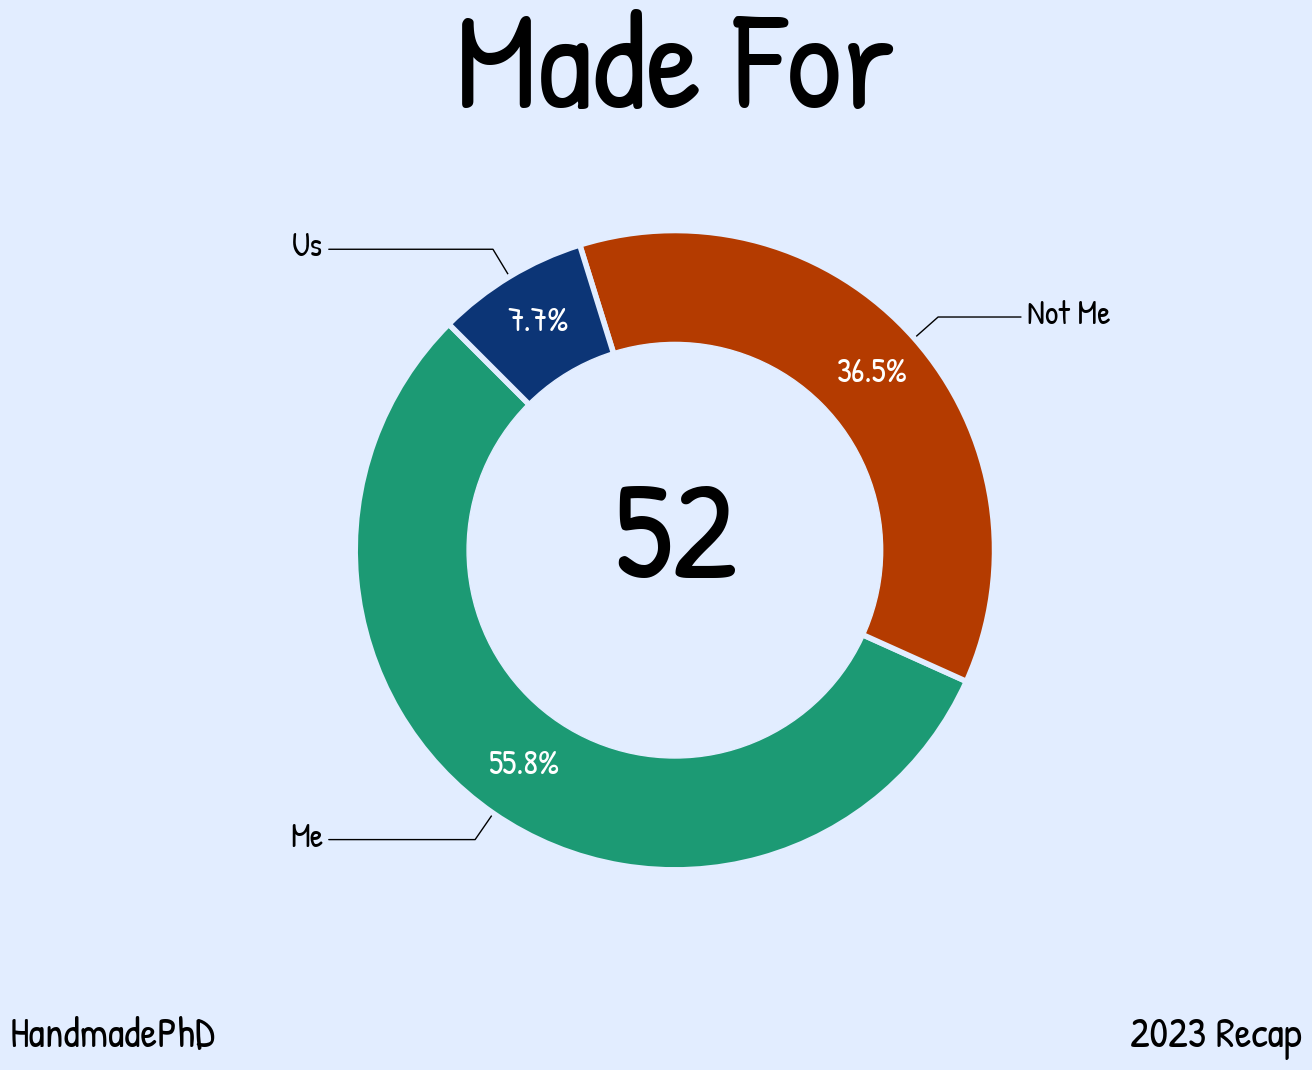

In [11]:
####
## Made for
####
var="MADE FOR"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Made For", fontsize=100, loc="center")
plt.savefig("made-for.png", dpi=100)

## Display the plot
plt.show()

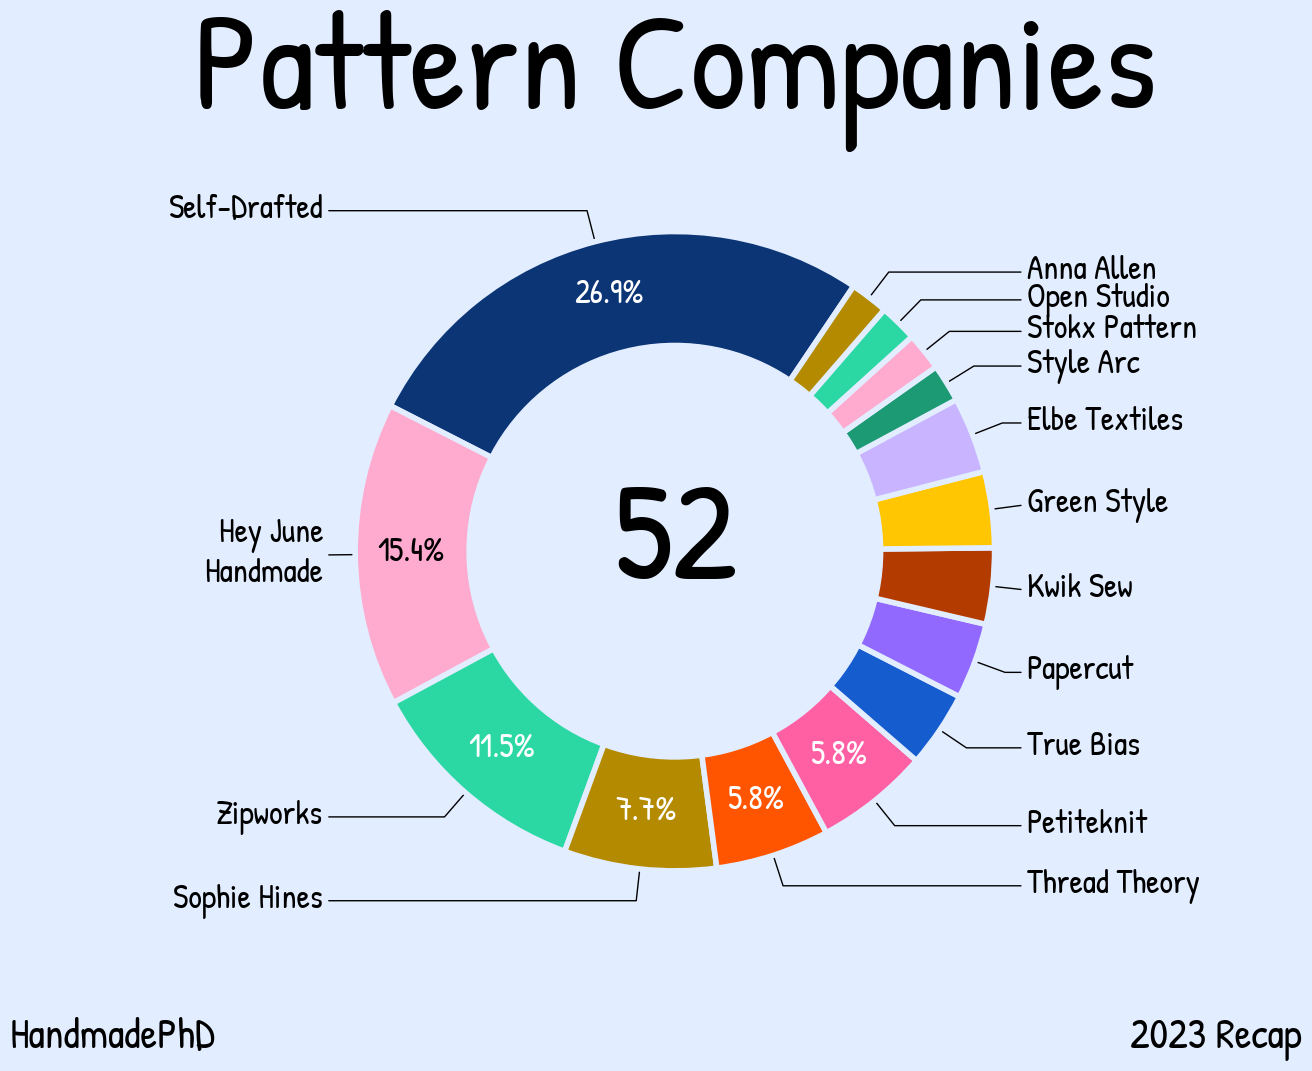

In [26]:
####
## Pattern companies
####
var="PATTERN COMPANY"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Pattern Companies", fontsize=100, loc="center")
plt.savefig("pattern-companies.png", dpi=100)

## Display the plot
plt.show()

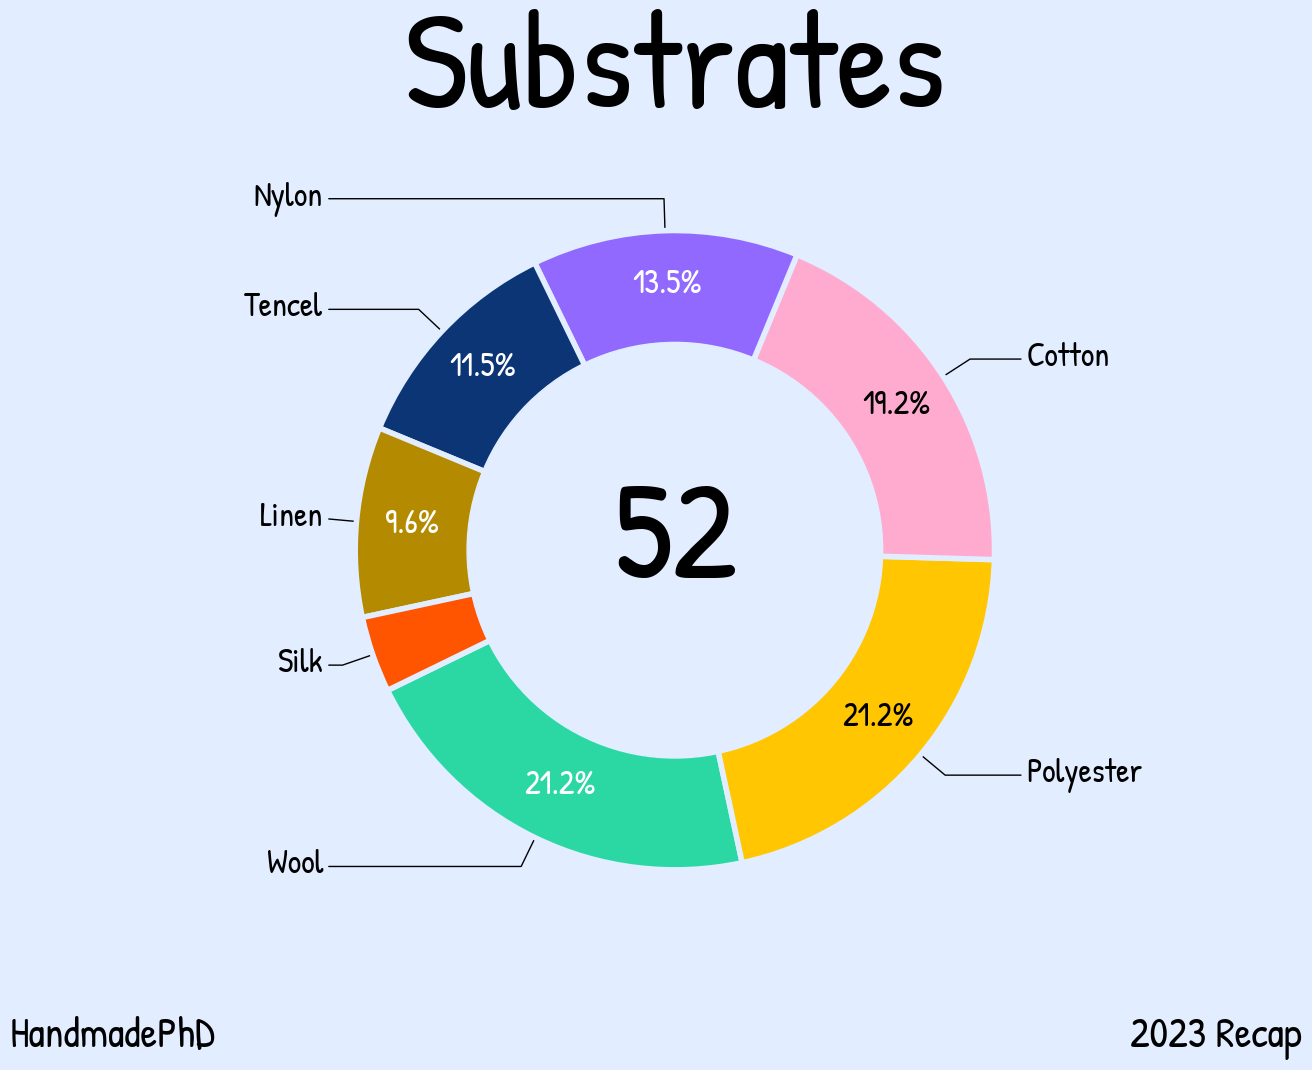

In [27]:
####
## Substrates
####
var="SUBSTRATE"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Substrates", fontsize=100, loc="center")
plt.savefig("substrates.png", dpi=100)

## Display the plot
plt.show()

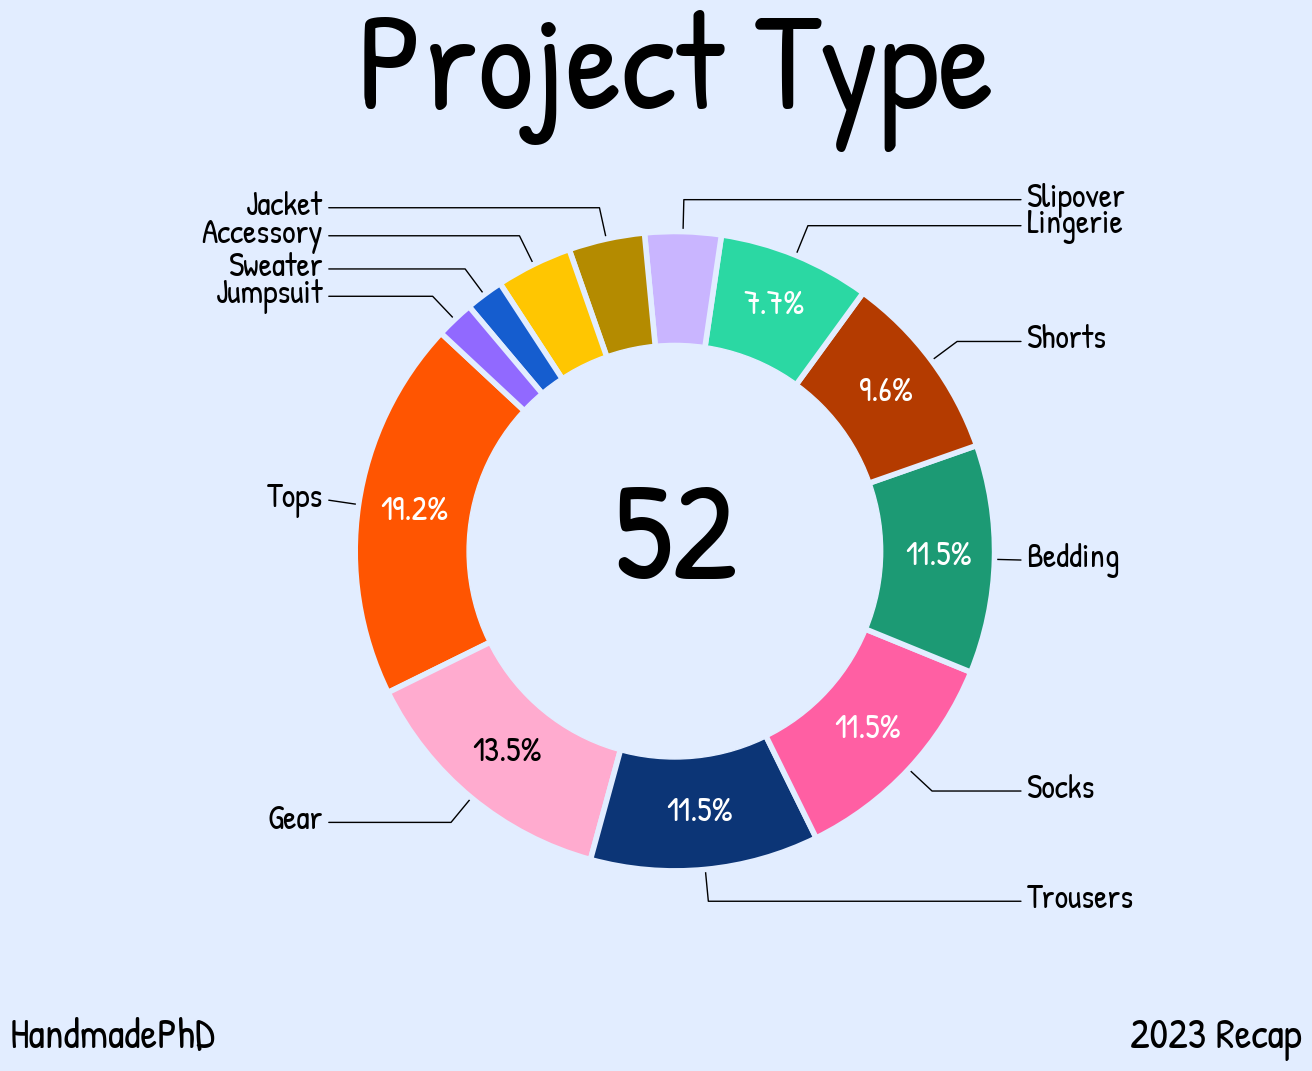

In [30]:
####
## Project type
####
var="PROJECT TYPE"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Project Type", fontsize=100, loc="center")
plt.savefig("project-type.png", dpi=100)

## Display the plot
plt.show()

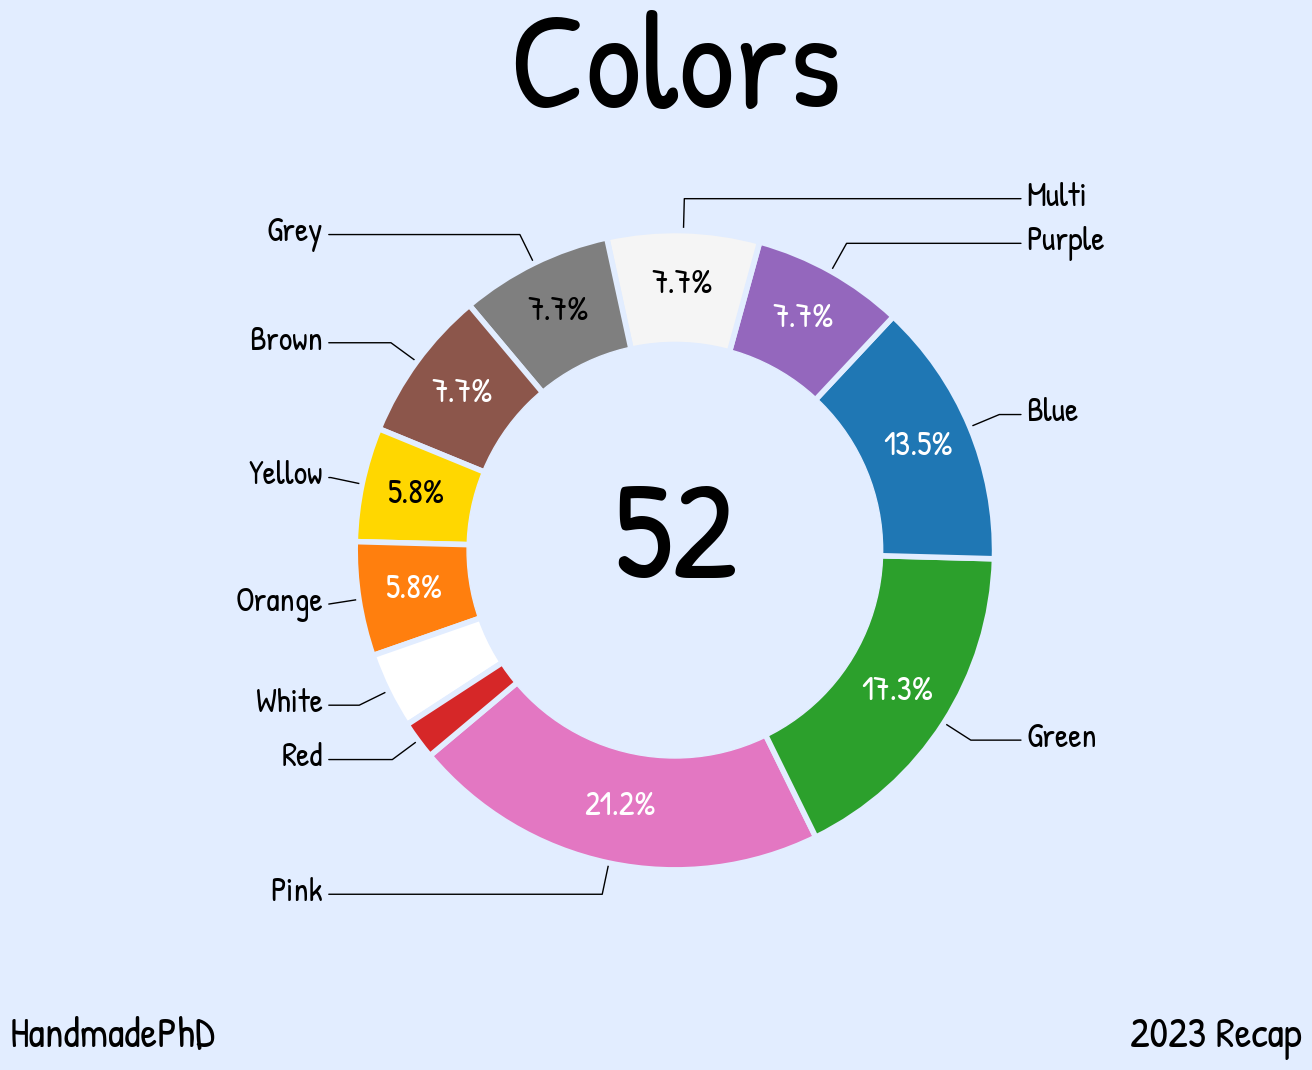

In [31]:
####
## Colors
####
var = "COLOR CATEGORY"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
colors=list(tab[var])
for i in range(len(colors)):
    if colors[i] == "White":
        colors[i] = "white"
    elif colors[i] == "Blue":
        colors[i] = "tab:blue"
    elif colors[i] == "Orange":
        colors[i] = "tab:orange"
    elif colors[i] == "Grey":
        colors[i] = "tab:gray"
    elif colors[i] == "Green":
        colors[i] = "tab:green"
    elif colors[i] == "Brown":
        colors[i] = "tab:brown"
    elif colors[i] == "Pink":
        colors[i] = "tab:pink"
    elif colors[i] == "Purple":
        colors[i] = "tab:purple"
    elif colors[i] == "Multi":
        colors[i] = "whitesmoke"
    elif colors[i] == "Yellow":
        colors[i] = "gold"
    elif colors[i] == "Red":
        colors[i] = "tab:red"
        
## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Colors", fontsize=100, loc="center")
plt.savefig("colors.png", dpi=100)

## Display the plot
plt.show()

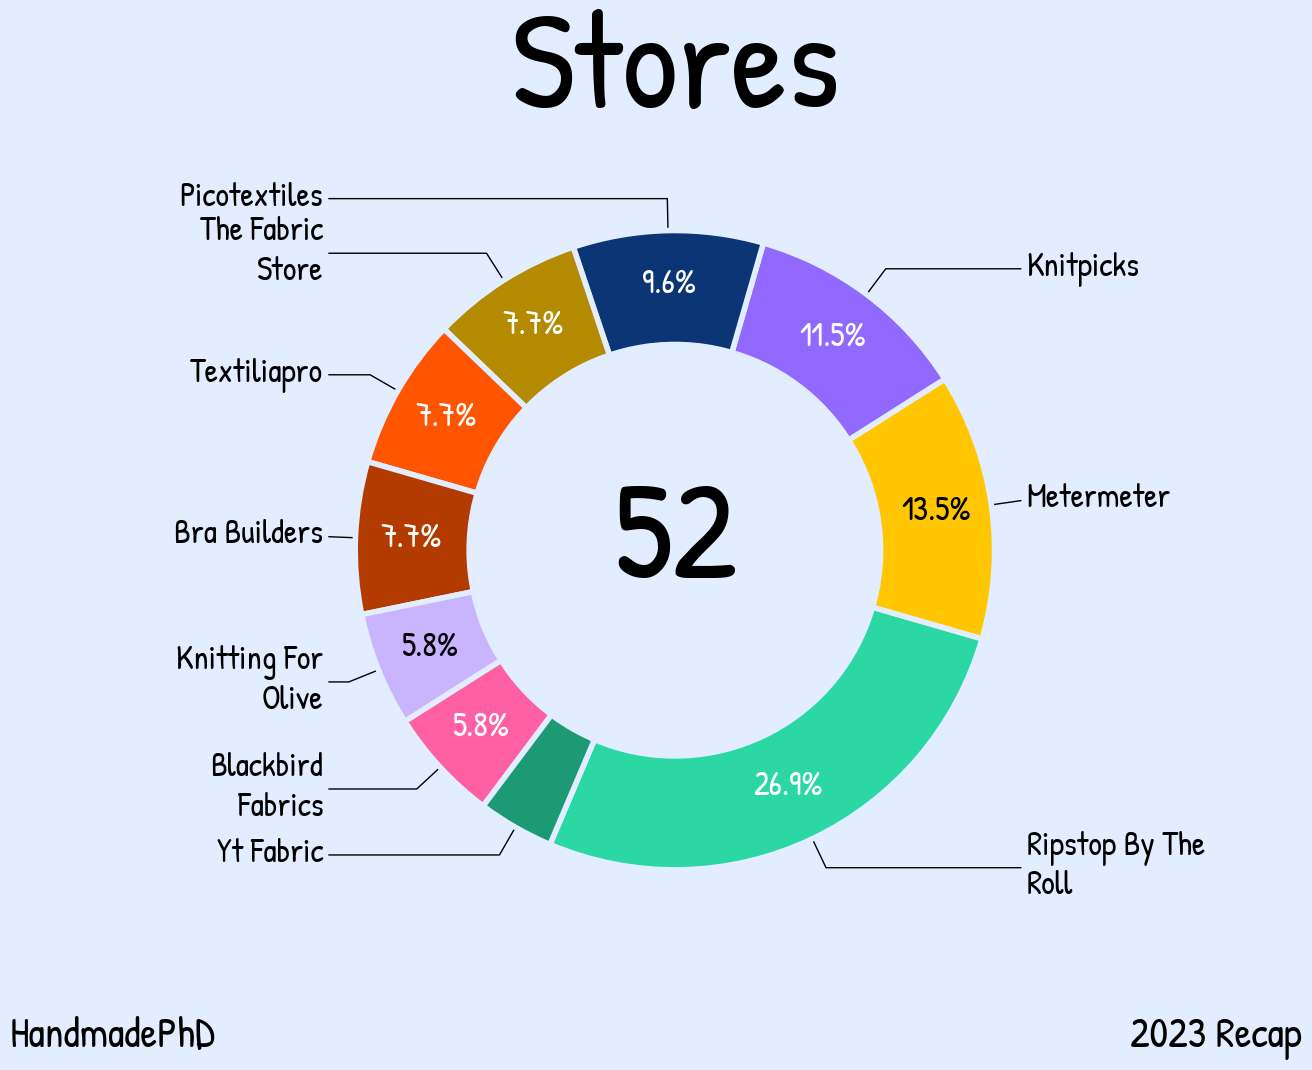

In [34]:
####
## Stores
####
var="VENDOR"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Stores", fontsize=100, loc="center")
plt.savefig("fabric-stores.png", dpi=100)

## Display the plot
plt.show()

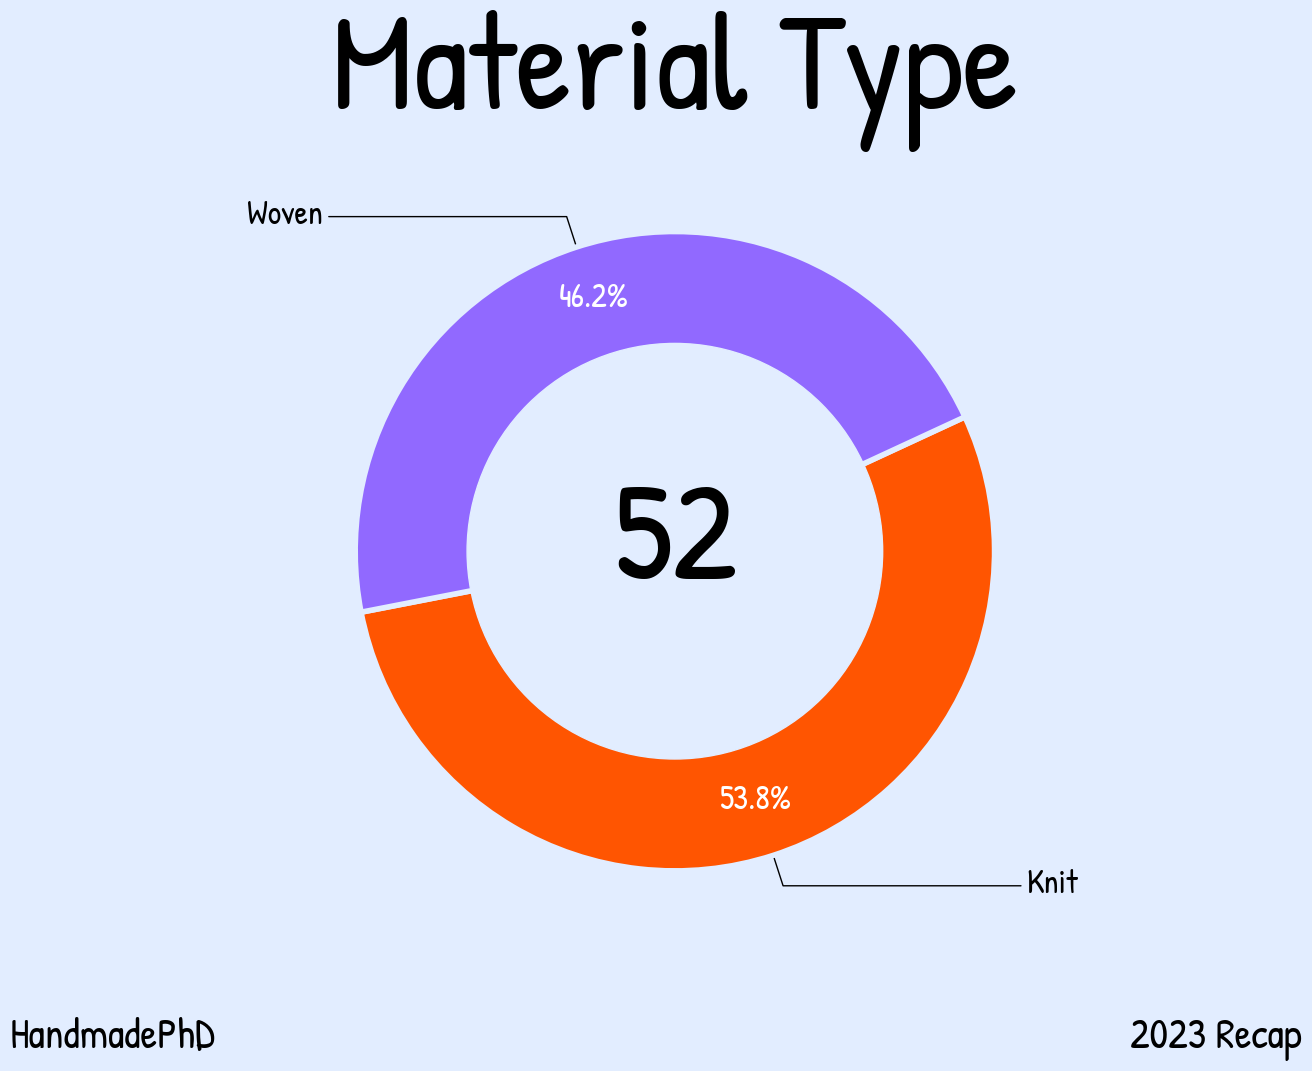

In [12]:
####
## Material type
####
var="FABRIC TYPE"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)
tab[var] = tab[var].str.title()

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Material Type", fontsize=100, loc="center")
plt.savefig("fabric-type.png", dpi=100)

## Display the plot
plt.show()

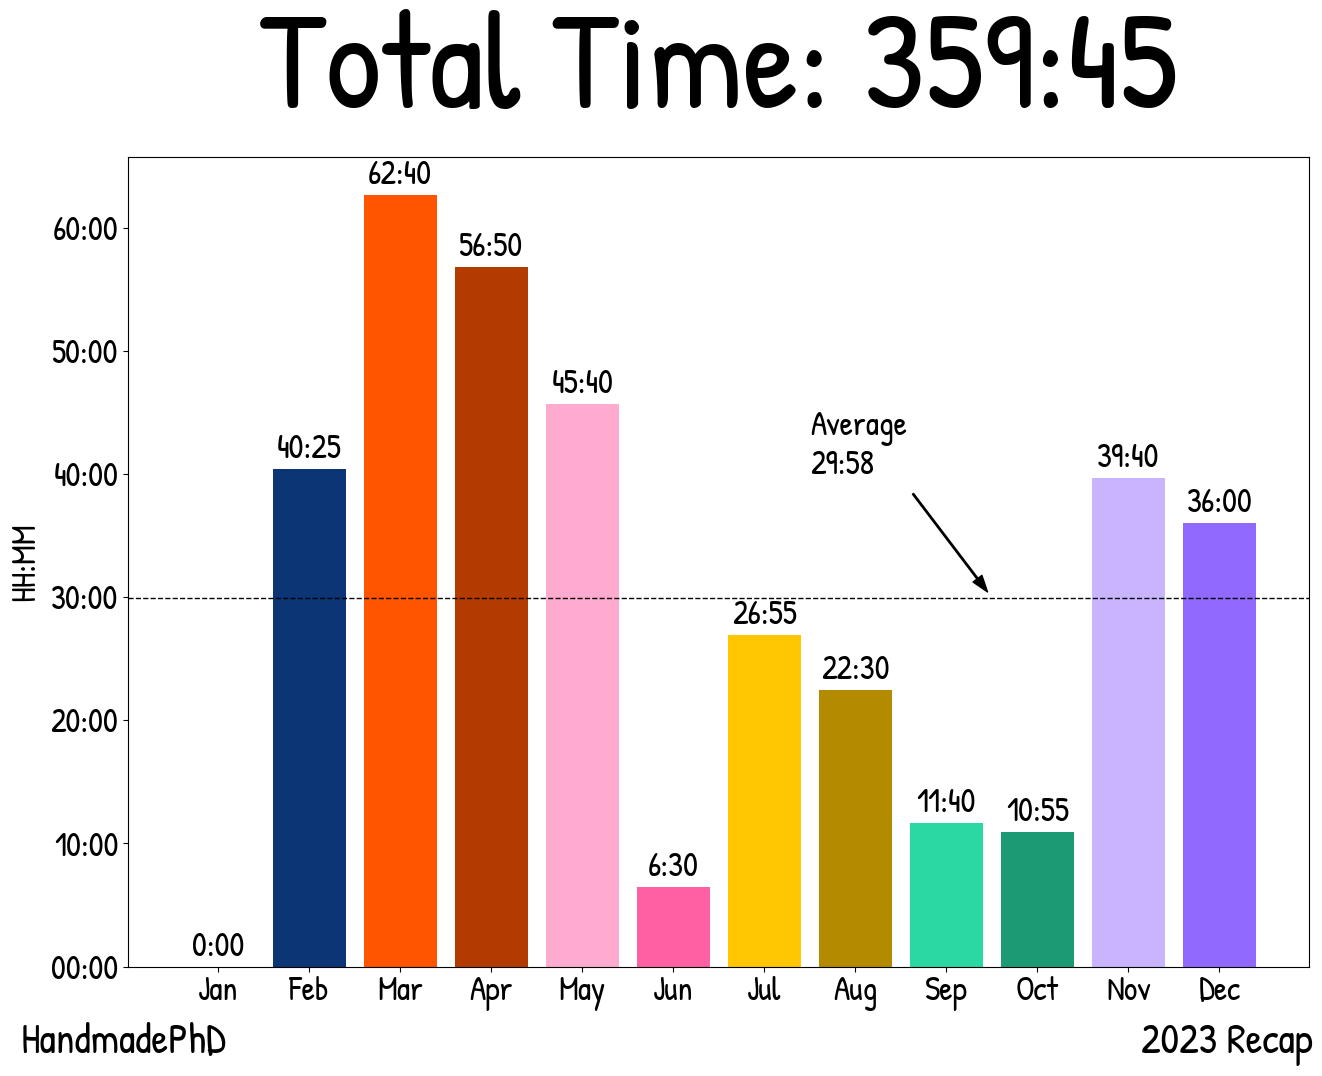

In [13]:
####
## Total time per month  
####

## Calculate the total time spent each month
result = df_TIME.groupby([df_TIME['DATE'].dt.month]).agg({'SECONDS': sum}).reset_index()

## Merge with a DataFrame containing month numbers (1 to 12), fill missing values with 0
result = pd.merge(result, pd.DataFrame(np.arange(1, 13), columns=["DATE"]), how="right").replace(np.nan, 0)

## Extract x and y values for plotting
x = result['DATE']
y = result['SECONDS']

## Set labels and title for the plot
labels = month_list
title = f"Total Time: {secondsToTime(sum(y))}"

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
bars = ax.bar(x, y, color=clrs)

## Add labels and formatting to the bars
ax.bar_label(bars, fmt=lambda x: "%d:%02d" % divmod(divmod(x, 60)[0], 60))

## Customize y-axis ticks and labels
yticks = interval(y.max(), 10, math.ceil((y.max()/3600/10)))
ax.set_yticks(yticks)
yticklabels = [time_dict[k] for k in yticks]
ax.set_yticklabels(yticklabels)

## Customize x-axis ticks and plot title
plt.xticks(x, labels)
plt.title(title, fontsize=100, pad=35)

## Remove y and x-axis labels
plt.ylabel("HH:MM")
plt.xlabel("")

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.1, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Calculate and plot the monthly average
mn = round(np.nanmean(y),2)
mn_text = secondsToTime(mn)
plt.axhline(y=mn, color='black', linestyle='--', linewidth=1, label='Avg')
plt.annotate(f"Average\n{mn_text}", xy=(9.5, mn), xytext=(7.5, mn+36000), arrowprops=dict(width=1, headwidth=8, facecolor='black', shrink=0.05)) 

## Save the figure as an image
plt.savefig("total-time.png", dpi=100)

## Display the plot
plt.show()

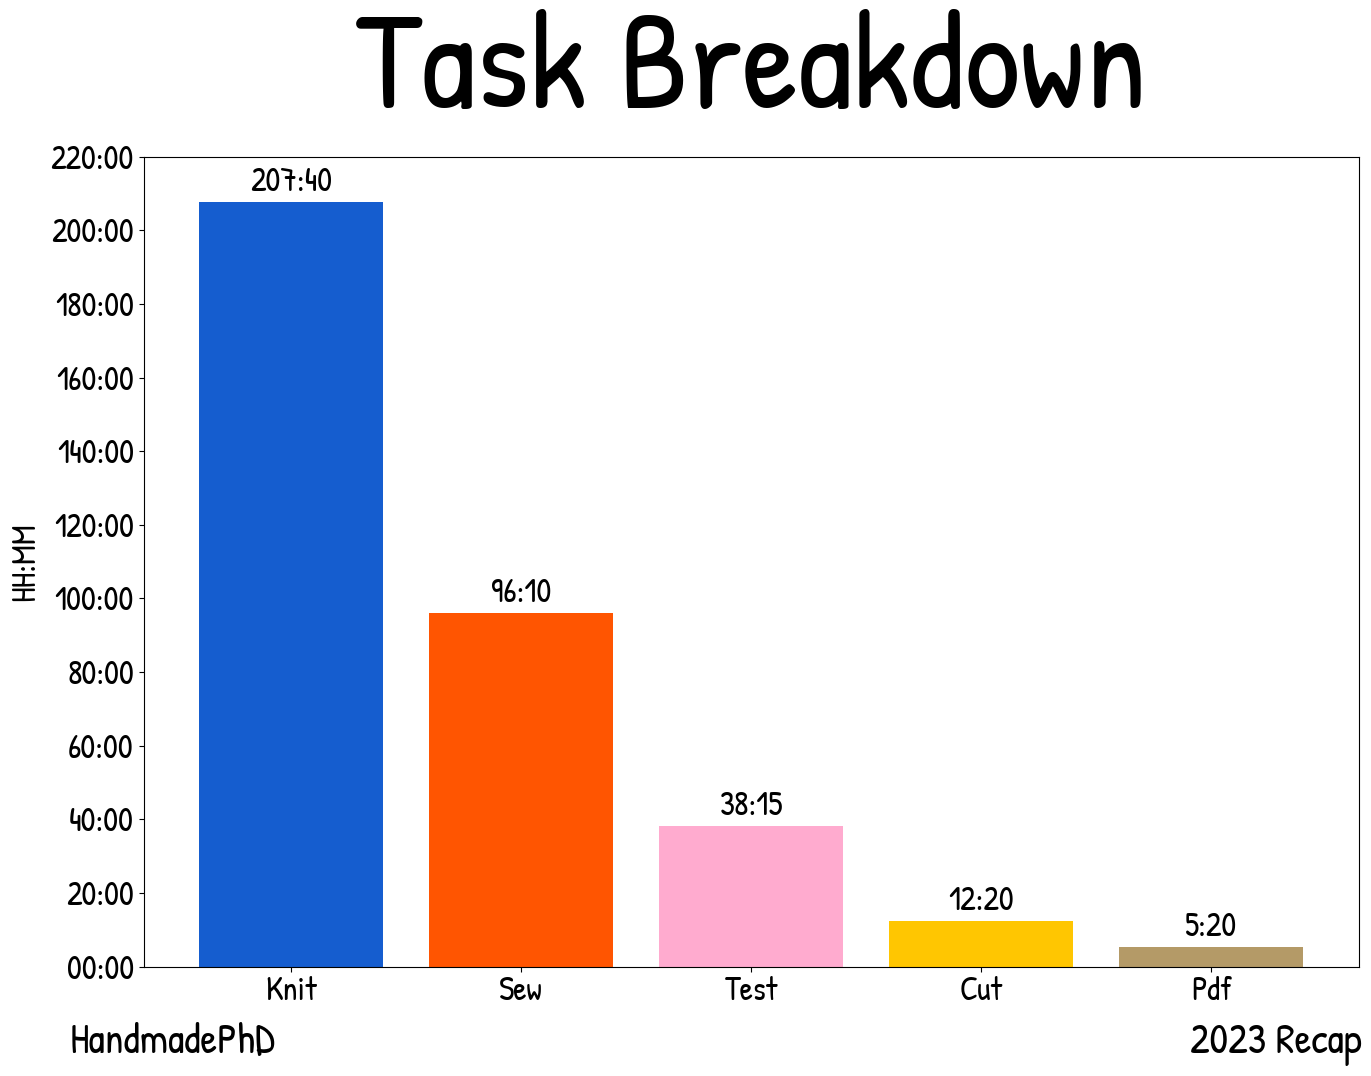

In [14]:
####
## Total time per task
####

## Create a frequency table for the specified variable and TASK, storing the result in 'tab'
var = "TASK"
tab = df_TIME.stb.freq([var], value="SECONDS")
tab_total = round(sum(tab["SECONDS"]), 2)
tab_total = (secondsToTime(tab_total))
tab[var] = tab[var].str.title()

## Extract x and y values for plotting
x = tab.TASK
y = tab["SECONDS"]

## Wrap labels using a custom function based on the category names
labels = custom_label(tab[var])

## Set labels and title for the plot
title = "Task Breakdown"

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
bars = ax.bar(x, y, color=["#155DCF", "#FF5501", "#FFABCF", "#FFC601", "#B49A67", "#2BD8A3", "#C9B5FF"])

## Add labels and formatting to the bars
ax.bar_label(bars, fmt=lambda x: "%d:%02d" % divmod(divmod(x, 60)[0], 60))

## Customize y-axis ticks and labels
yticks = interval(y.max(), 20, math.ceil((y.max()/3600)))
ax.set_yticks(yticks)
yticklabels = [time_dict[k] for k in yticks]
ax.set_yticklabels(yticklabels)

## Customize x-axis ticks and title
plt.xticks(x, labels)
plt.title(title, fontsize=100, pad=35)

## Remove y and x-axis labels
plt.ylabel("HH:MM")
plt.xlabel("")

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.075, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Save the figure as an image
plt.savefig("task-breakdown.png", dpi=100)

## Display the plot
plt.show()

In [39]:
####
## Time per project
####
time_project = df_TIME.stb.freq(["PROJECT NAME"], value="SECONDS")
time_project = time_project.iloc[:, 0:2]

## Extract the latest date for each project
for p in df_TIME["PROJECT NAME"].unique():
    time_project.loc[time_project["PROJECT NAME"]==p, "DATE"] = df_TIME.loc[df_TIME["PROJECT NAME"]==p, "DATE"].max()

## Remove projects with no completion date
for p in df_TIME["PROJECT NAME"].unique():
    strdate = df_TIME.loc[(df_TIME["TASK"]=="COMPLETE") & (df_TIME["PROJECT NAME"]==p), "DATE"].max()
    if pd.isna(strdate) == True:
        time_project.drop(time_project[time_project["PROJECT NAME"]==p].index, inplace=True)

## Add project type
time_project["TYPE"] = time_project['PROJECT NAME'].map(type_dict)
time_project = time_project.sort_values(by=["TYPE", "DATE", "PROJECT NAME"])
print(time_project[(time_project["TYPE"] == "SOCKS") | (time_project["TYPE"] == "SLIPOVER") | (time_project["TYPE"] == "SWEATER")]["SECONDS"].sum())

####
## Days per project
####
day_project=pd.DataFrame(columns=list("ABC"))
for p in df_TIME["PROJECT NAME"].unique():
    sta = df_TIME.loc[df_TIME["PROJECT NAME"]==p, "DATE"].min()
    end = df_TIME.loc[df_TIME["PROJECT NAME"]==p, "DATE"].max()
    row_to_append = pd.DataFrame([[p, sta, end]], columns=list("ABC"))
    day_project = pd.concat([day_project,row_to_append])

day_project["D"] = (day_project["C"] - day_project["B"]).dt.days
day_project = day_project.reset_index().drop("index", axis=1)
for p in df_TIME["PROJECT NAME"].unique():
    strdate = df_TIME.loc[(df_TIME["TASK"]=="COMPLETE") & (df_TIME["PROJECT NAME"]==p), "DATE"].max()
    if pd.isna(strdate) == True:
        day_project.drop(day_project[day_project["A"]==p].index, inplace=True)

day_project.columns = ["PROJECT NAME", "START", "END", "DAYS"]
day_project = pd.DataFrame(day_project.to_records(index=False))
day_project["DAYS"] = day_project["DAYS"] + 1

## Add project type
day_project["TYPE"] = day_project['PROJECT NAME'].map(type_dict)
day_project = day_project.sort_values(by=["TYPE","END"])

####
## Merge time and days
####
tab = pd.merge(time_project, day_project, on=["PROJECT NAME", "TYPE"], how="outer")
tab['SECONDS'] = tab['SECONDS'].fillna(0)
tab = tab.groupby('TYPE').agg({'SECONDS':'mean', 'DAYS':'mean'})
tab.index = tab.index.str.title()

####
## Set color by project type
####
wrapped_labels = tab.index.unique()
custom_wedges()
type_color_dict = dict(zip(wrapped_labels, colors))
type_color = tab.index.map(type_color_dict).to_list()

655200


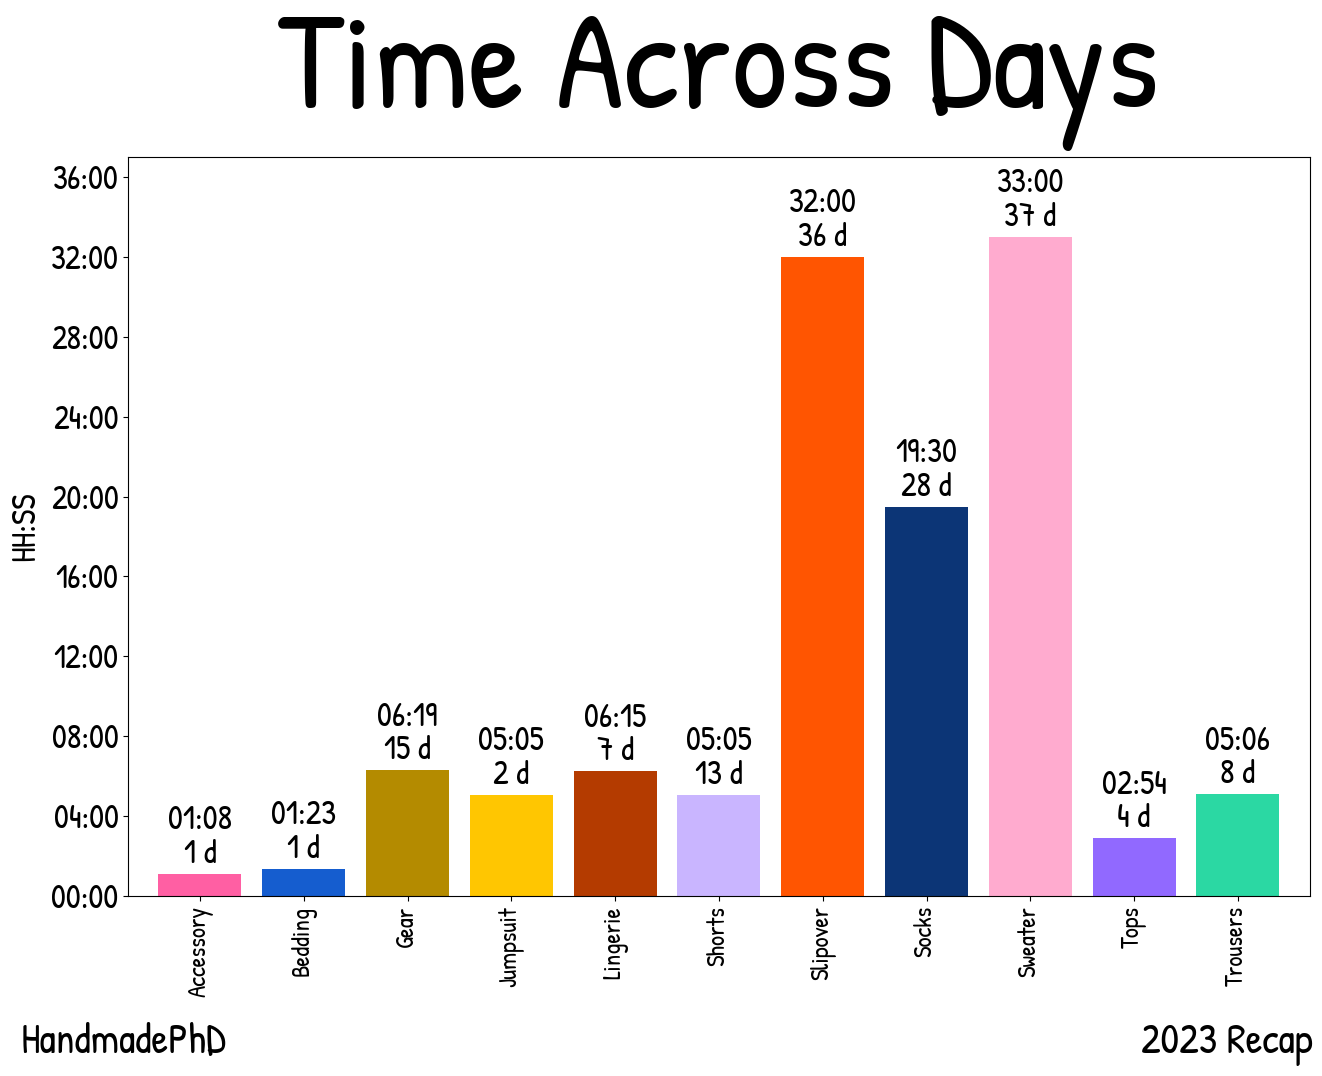

In [16]:
####
## Time across days by project type
####
## Set y-axis ticks for time data
time_max = tab['SECONDS'].max()
time_yticks = interval(time_max, 4, math.ceil((time_max/3600)))

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)

## Plot time
bars = ax.bar(tab.index, tab["SECONDS"], color=type_color)

## Add day labels
ax.bar_label(bars, labels=[f'{e:,.0f} d' for e in tab["DAYS"]])
ax.bar_label(bars, fmt=lambda x: "%02d:%02d" % divmod(divmod(x, 60)[0], 60), padding=24)

## Grid
# plt.grid(axis='y', linestyle = '--', linewidth = 0.5)

## Customize plot title and x and y labels
plt.title("Time Across Days", fontsize=100, pad=35)
ax.set_xlabel("")
ax.set_ylabel("HH:SS")

## Customize x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=18)

## Customize y-tick labels for time
plt.ylim(0, 133200) 
ax.set_yticks(time_yticks)
labels = [time_dict[k] for k in time_yticks]
ax.set_yticklabels(labels)
    
## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.1, right=0.975, top=0.85, bottom=0.165)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Adjust xlim
left, right = ax.get_xlim() # return the current xlim
ax.set_xlim((left+0.25, right-0.25))

## Save the figure as an image
plt.savefig("time-project.png", dpi=100)
plt.show()

Amount Ordered    64.542423
Amount Used       65.622623
dtype: float64


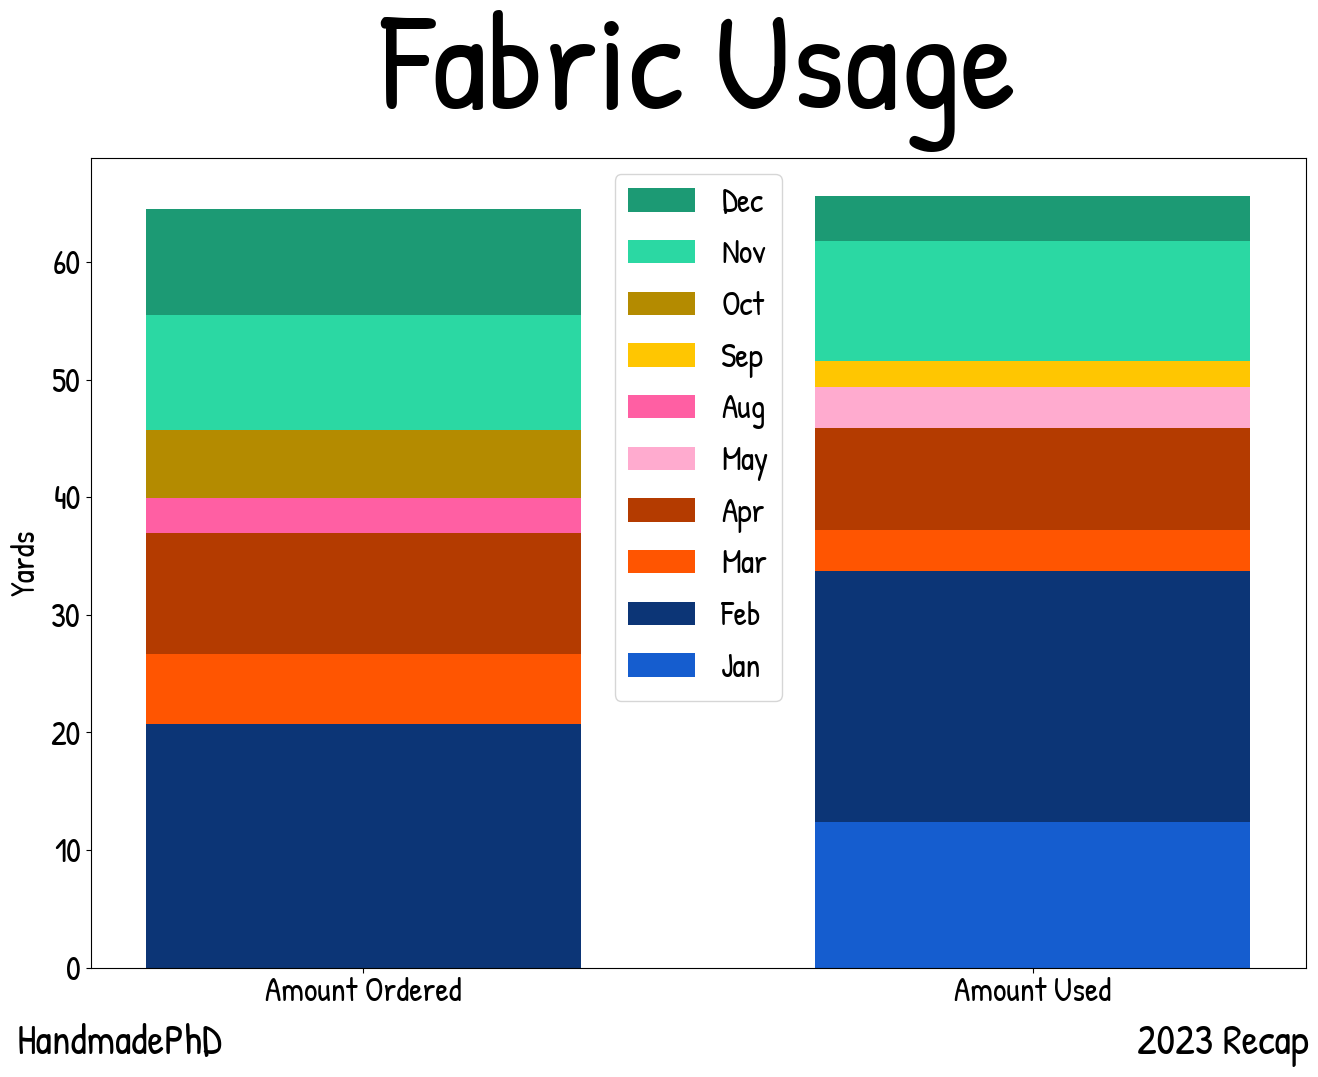

In [17]:
####
## Fabric bought vs used
####

## Subset for sewing projects only
df_PROJECTSS = df_PROJECTS[(df_PROJECTS["METHOD"] == "SEW")]
conv = {"YD": {"YD": 1, "M": 1.093613}}
for col, unit in [("AMOUNT ORDERED", "YD"), ("AMOUNT USED", "YD")]:
    df_PROJECTSS[col] = df_PROJECTSS[col] * df_PROJECTSS[f"{col} UNIT"].map(conv[unit])
    df_PROJECTSS[f"{col} UNIT"] = unit
    
## Calculate sum of amount ordered and amount used per month
df1 = df_PROJECTSS[df_PROJECTSS["PURCHASED"].dt.strftime("%Y-%m") >= "2023-01"]
df1 = df1.groupby(pd.Grouper(key='PURCHASED',freq='M'))['AMOUNT ORDERED'].sum().fillna(0)
df2 = df_PROJECTSS[df_PROJECTSS["PROJECT COMPLETED"].dt.strftime("%Y-%m") >= "2023-01"]
df2 = df2.groupby(pd.Grouper(key='PROJECT COMPLETED',freq='M'))['AMOUNT USED'].sum().fillna(0)

## Create new DataFrame
df3 = pd.concat([df1, df2], axis=1)
df3.index = pd.to_datetime(df3.index)
df3.index = df3.index.strftime("%b")
df3['MONTHS'] = df3.index
df3['MONTHS'] = df3['MONTHS'].str.upper()
df3 = df3[['MONTHS', 'AMOUNT ORDERED', 'AMOUNT USED']]

## Transpose DataFrame
df4 = df3.transpose()
headers = df4.iloc[0].values
df4.columns = headers
df4 = df4.iloc[1:, :]
df4.replace(np.NaN, 0, inplace=True)
df4 = df4.loc[:, (df4 != 0).any(axis=0)]
df4.columns = df4.columns.str.title()
df4.index = df4.index.str.title()
print(df4.sum(axis=1))

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
for i,col in enumerate(df4.columns):
    ax.bar(df4.index, height=df4[col], bottom=df4.iloc[:,:i].sum(axis=1), color=clrs[i], label=col, width=0.65)

## Customize plot title and x and y labels
plt.title("Fabric Usage", fontsize=100, pad=35)
plt.ylabel("Yards")
plt.xlabel("")

## Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper center')  # reverse to keep order consistent

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.075, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Save the figure as an image    
plt.savefig("monthly-fabric-usage.png", dpi=100)
plt.show()

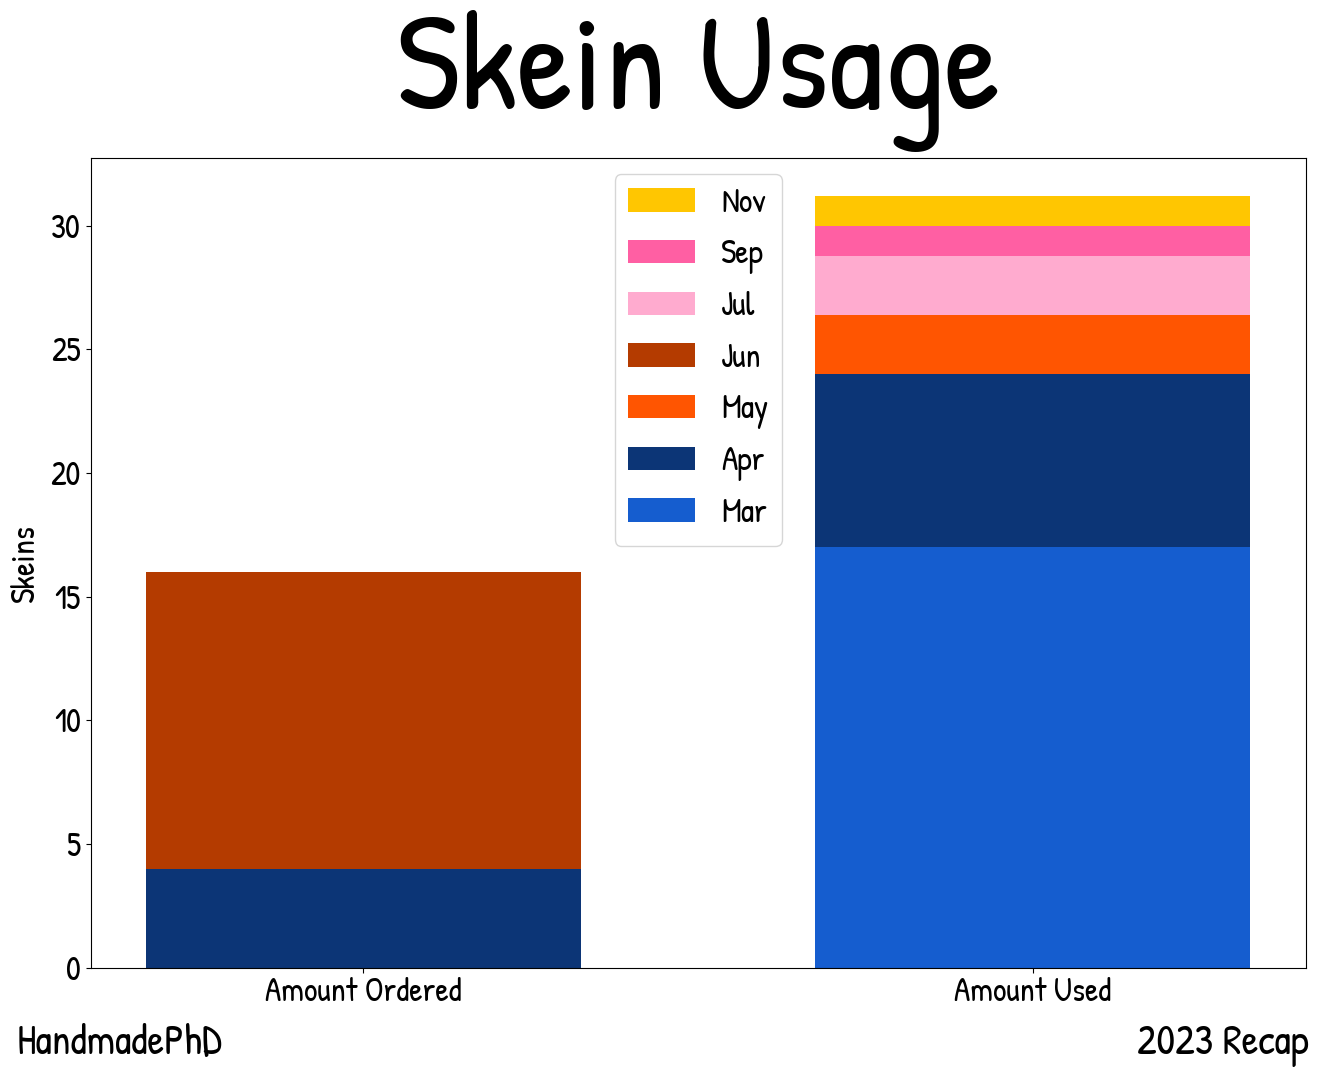

In [18]:
####
## Yarn bought vs used
####

## Subset for knitting projects only
df_PROJECTSK = df_PROJECTS[(df_PROJECTS["METHOD"] == "KNIT")]

## Calculate sum of amount ordered and amount used per month
df1 = df_PROJECTSK[df_PROJECTSK["PURCHASED"].dt.strftime("%Y-%m") >= "2023-01"]
df1 = df1.groupby(pd.Grouper(key='PURCHASED',freq='M'))['AMOUNT ORDERED'].sum().fillna(0)
df2 = df_PROJECTSK[df_PROJECTSK["PROJECT COMPLETED"].dt.strftime("%Y-%m") >= "2023-01"]
df2 = df2.groupby(pd.Grouper(key='PROJECT COMPLETED',freq='M'))['AMOUNT USED'].sum().fillna(0)

## Create new DataFrame
df3 = pd.concat([df1, df2], axis=1)
df3.index = pd.to_datetime(df3.index)
df3.index = df3.index.strftime("%b")
df3['MONTHS'] = df3.index
df3['MONTHS'] = df3['MONTHS'].str.upper()
df3 = df3[['MONTHS', 'AMOUNT ORDERED', 'AMOUNT USED']]

## Transpose DataFrame
df4 = df3.transpose()
headers = df4.iloc[0].values
df4.columns = headers
df4 = df4.iloc[1:, :]
df4.replace(np.NaN, 0, inplace=True)
df4 = df4.loc[:, (df4 != 0).any(axis=0)]
df4.columns = df4.columns.str.title()
df4.index = df4.index.str.title()

## Create a bar plot
fig, ax = plt.subplots(figsize=(1350/100, 1080/100), dpi=100)
for i,col in enumerate(df4.columns):
    ax.bar(df4.index, height=df4[col], bottom=df4.iloc[:,:i].sum(axis=1), color=clrs[i], label=col, width=0.65)

## Customize plot title and x and y labels
plt.title("Skein Usage", fontsize=100, pad=35)
plt.ylabel("Skeins")
plt.xlabel("")

## Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper center')  # reverse to keep order consistent

## Adjust layout for better aesthetics
plt.subplots_adjust(left=0.075, right=0.975, top=0.85, bottom=0.1)

## Add username and month label as text
plt.text(0.02, 0.02, username, fontsize=30, transform=plt.gcf().transFigure)
plt.text(0.85, 0.02, month_label, fontsize=30, transform=plt.gcf().transFigure)

## Save the figure as an image    
plt.savefig("monthly-skein-usage.png", dpi=100)
plt.show()

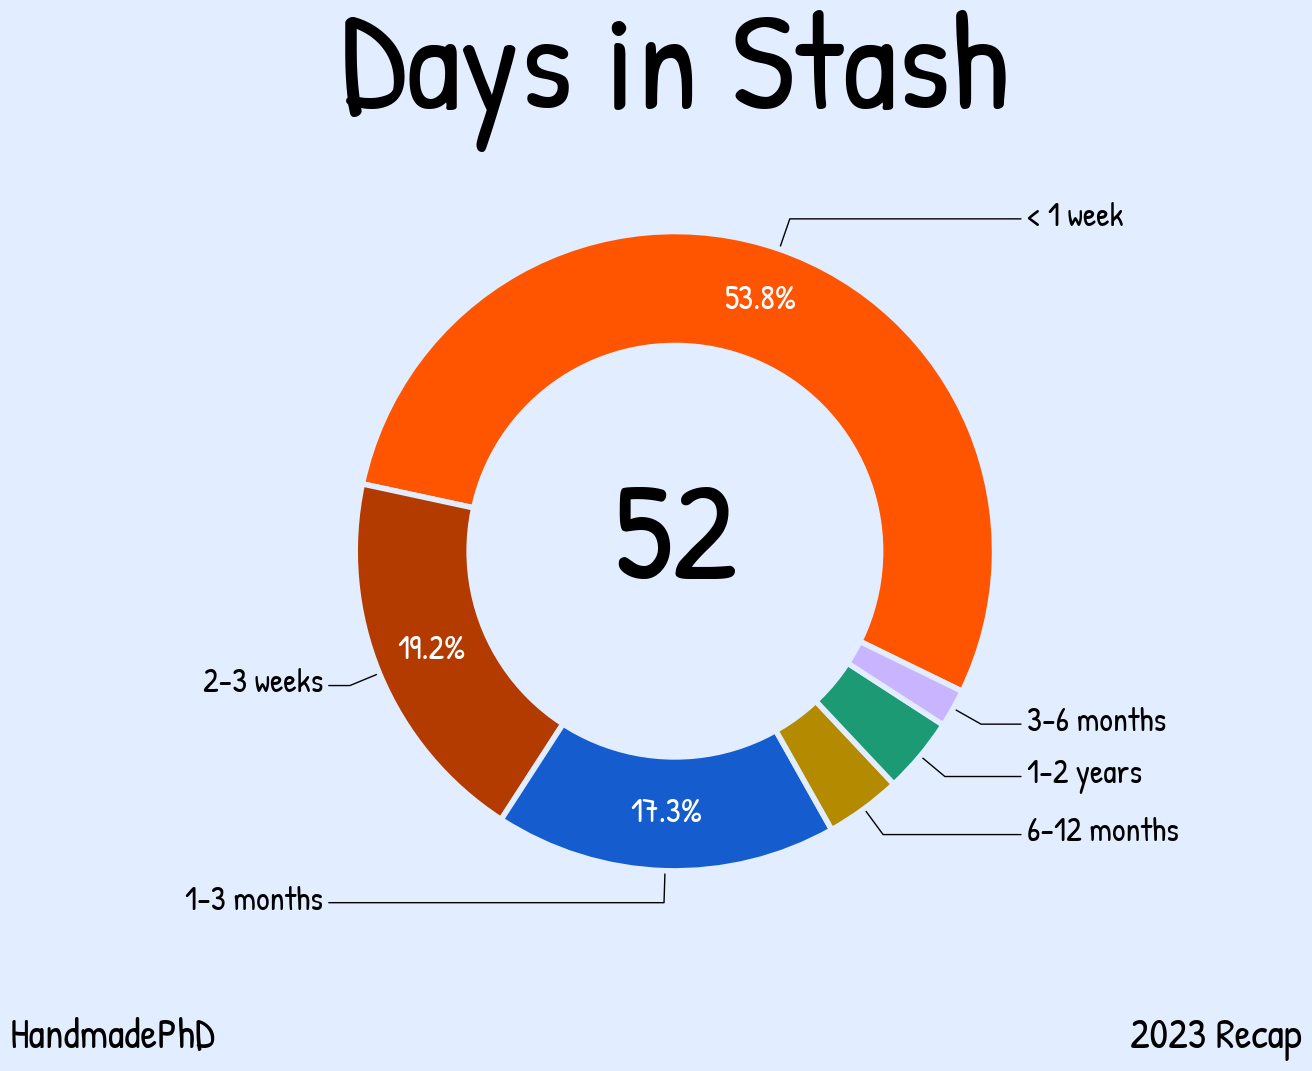

In [20]:
####
## Days in stash
####
df_PROJECTS['DAYS IN STASH'] = df_PROJECTS['DAYS IN STASH'].fillna(0)

# Define bins for categorizing days in stash
bins = [-1, 7, 30, 90, 182, 365, 730, np.inf]
names = ['< 1 week', '2-3 weeks', '1-3 months', '3-6 months', '6-12 months', '1-2 years', '2+ years']

# Create a new column with categories based on days in stash
df_PROJECTS['DAYS IN STASH CATEGORY'] = pd.cut(df_PROJECTS['DAYS IN STASH'], bins, labels=names)

# Tabulate
var = "DAYS IN STASH CATEGORY"
tab = df_PROJECTS.groupby([df_PROJECTS['PROJECT COMPLETED'].dt.month, 'PROJECT NAME']).agg({var: "unique"}).reset_index()
tab[var] = tab[var].str[0]
tab = tab.stb.freq([var])
tab_total = round(sum(tab["count"]),0)

## Customize labels for the pie chart wedges
custom_label(tab[var])

## Generate colors for the pie chart wedges
custom_wedges()

## Generate and display the custom project pie chart
pctscolors = [clrs_txt[k] for k in colors]
custom_project_piechart()

## Save the figure as an image with a specific title
plt.title("Days in Stash", fontsize=100, loc="center")
plt.savefig("monthly-stash.png", dpi=100)

## Display the plot
plt.show()

In [ ]:
#######################
## HELPFUL INFORMATION
#######################

## tab:blue : #1f77b4
## tab:orange : #ff7f0e
## tab:green : #2ca02c
## tab:red : #d62728
## tab:purple : #9467bd
## tab:brown : #8c564b
## tab:pink : #e377c2
## tab:gray : #7f7f7f
## tab:olive : #bcbd22
## tab:cyan : #17becf